# Vehicle Segmentation

In this notebook, we are going to address the **Vehicle Segmentation** task using *Poland cars for sale dataset (200k adverts)* from Kaggle. 

**In order to smooth run of this notebook, make sure you have csv for the car dataset stored in the same folder as this notebook in your repo.**

## Library & Data Import

In [1]:
#### supress warnings ####
import warnings
warnings.filterwarnings('ignore')

#### Import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter,ScalarFormatter

#### Remove Scientic Notation While Displaying Pandas Data
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
car_sales_df = pd.read_csv('Car_sale_ads.csv') #### Read csv as dataframe 
car_sales_df.head(3) 

,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,...,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
0,0,86200,PLN,New,Abarth,595,NaN,NaN,2021,1.000,...,Manual,small_cars,3.000,gray,NaN,NaN,NaN,04/05/2021,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[]
1,1,43500,PLN,Used,Abarth,Other,NaN,NaN,1974,59000.000,...,Manual,coupe,2.000,silver,NaN,NaN,NaN,03/05/2021,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[]
2,2,44900,PLN,Used,Abarth,500,NaN,NaN,2018,52000.000,...,Automatic,small_cars,3.000,silver,NaN,NaN,NaN,03/05/2021,"Warszawa, Mazowieckie, Białołęka","['ABS', 'Electric front windows', 'Drivers air..."


## Functions

In [3]:
def plot_hist(df,col,bins,x_label,kde=False,formatter=True,skewness=False):
    """This function plots histogram using seaborn for given dataframe column & granularity

    Args:
        df (dataframe): input dataframe
        col (string): column name for which histogram is plotted
        bins (integer): histogram binning granularity 
        x_label (string): X axis label 
        kde (boolean): Flag indicating addition of kde parameter
        formatter (boolean): Flag to tweak scientific notation
        skewness (boolean): Flag indication addition of skew calculation
        
    Returns:
        skew: skew value of column distribution
    """    
    plt.figure(figsize=(12, 8))  # Width: 12, Height: 8
    sns.histplot(df[col],bins=bins, color='blue')
    plt.title('Distribution of '+col)
    plt.xlabel(x_label)
    plt.ylabel('Frequency')

    if(formatter):
        # Remove scientific notation
        ax = plt.gca()  # Get the current axes
        ax.ticklabel_format(style='plain', axis='both')  # Set plain formatting for both axes

    plt.xticks(rotation=90)
    plt.show()
    
    return 

## Preliminary Data Check

The goal of this section is to look at basic skeleton & overall stats of the dataset so we can plan the data cleaning & pre-processing tasks further.

In [4]:
#### Get Total Row & Column Count 
rows, columns = car_sales_df.shape
print(f"Rows: {rows}, Columns: {columns}")

Rows: 208304, Columns: 25


In [5]:
car_sales_df.dtypes

Index                        int64
Price                        int64
Currency                    object
Condition                   object
Vehicle_brand               object
Vehicle_model               object
Vehicle_version             object
Vehicle_generation          object
Production_year              int64
Mileage_km                 float64
Power_HP                   float64
Displacement_cm3           float64
Fuel_type                   object
CO2_emissions              float64
Drive                       object
Transmission                object
Type                        object
Doors_number               float64
Colour                      object
Origin_country              object
First_owner                 object
First_registration_date     object
Offer_publication_date      object
Offer_location              object
Features                    object
dtype: object

In [6]:
#### Explore Columns & Data Types
type_dct = {str(k): list(v) for k, v in car_sales_df.groupby(car_sales_df.dtypes, axis=1)}

print('Number of Integer Columns', len(type_dct['int64']))
print('Number of Float Columns', len(type_dct['float64']))
print('Number of Object Columns', len(type_dct['object']))

Number of Integer Columns 3
Number of Float Columns 5
Number of Object Columns 17


As we can see majority of the columns are object, followed by Integer & Float. Most probably, the object columns would be categorical columns & the other 2 would be ordinal & cardinal in nature.

In [7]:
#### Explore basic stats for int & float columns
num_cols = list(type_dct['int64']) + list(type_dct['float64'])

num_cols.pop(0) #### remove the Index column

car_sales_df[num_cols].describe()

,Price,Production_year,Mileage_km,Power_HP,Displacement_cm3,CO2_emissions,Doors_number
count,208304.000,208304.000,207321.000,207661.000,206338.000,94047.000,206817.000
mean,63053.834,2012.098,150276.764,151.836,1882.567,319156.381,4.637
std,86659.673,6.998,2937446.805,77.684,729.610,72913958.705,0.769
min,500.000,1915.000,1.000,1.000,400.000,1.000,1.000
25%,17800.000,2008.000,53000.000,105.000,1461.000,120.000,5.000
50%,35700.000,2013.000,144566.000,136.000,1798.000,140.000,5.000
75%,75990.000,2017.000,206000.000,172.000,1997.000,164.000,5.000
max,6999000.000,2021.000,1111111111.000,1398.000,8400.000,20000000000.000,55.000


We see not all columns have row count matching with total number count from Dataframe. **This indicates possibility of missing values (Null / NaNs)**

The row count for both Integer columns, Price & Production_Year match with total row count of dataframe. This is not the case for any of the float columns. Thus, all the Null/NaN values would be present in Float & potentially Object type columns.

**First impressions:**


- The **price column** is integer and is minimum of 500 & Max of 69,99,000. From the first inspection, both these values seem like outliers. 

- The **production_year** column is pretty straighforward, since it's time column, only min & max values are of significance & both of them are normal. 1915 seems to be vintage car & max value of 2021 indicates latest model.

- For float columns, **Mileage_km & CO2_emissions** seem to have outliers for the max value. For all of the float columns except for Displacement_cm3, the min value is 1. The minimum of 1 might be corresponding to latest / new cars. Further inspection is needed.**

- The **Feature_Count** columns we created has number of features for each row / car in dataframe. As expected the minimum for it is 0 & Maximum for it is 77. The max is not very high but can still be an outlier.

In [8]:
#### Check numerical columns for negative values anomalies

car_sales_num_col_df = car_sales_df[num_cols]

negative_rows = car_sales_num_col_df[(car_sales_num_col_df < 0).any(axis=1)]

print('Row Count With Negative',len(negative_rows))

Row Count With Negative 0


**Conclusion:** The data seems to have missing entries as well as outliers for some of its columns. Further inspection is needed. 

## Null Values Check

Now we will do missing value check or null value check

In [9]:
#### Get list of columns with Null / NaN values & their percentage count

(car_sales_df.isnull().sum() / len(car_sales_df) * 100).loc[lambda x: x > 0].sort_values(ascending=False).apply(lambda x: f"{x:.2f}%")

First_owner                68.75%
First_registration_date    58.50%
CO2_emissions              54.85%
Origin_country             43.20%
Vehicle_version            33.71%
Vehicle_generation         29.02%
Drive                       7.24%
Displacement_cm3            0.94%
Doors_number                0.71%
Mileage_km                  0.47%
Power_HP                    0.31%
Transmission                0.23%
dtype: object

**Conclusion:** There are 12 columns out of 24 that have null values. Following columns have 30% or more observations missing:
- First Owner
- First Registration Date
- CO2 emission amount
- Origin Country
- Vehicle version
- Vehicle_generation

## Null Values Replacement 

As we saw, almost half of the 24 columns have missing entries & none of these 12 columns that have missing entries could be dropped since most of them provide crucial information about the car property that could be used as a feature for the segmentation.

Thus, we would need individual strategy for each column to fill the gaps.

To do this, we would use **Data Imputation Techniques**  on the columns where there are missing values or nulls. There are 12 columns with Nulls. Out of the 12, following columns could be easily imputed since these are categorical columns with little to no anomalies.

- First_owner 
- Origin_country
- Vehicle_version 
- Vehicle_generation 
- Drive 
- Transmission 

For First Owner, we will replace null with 'Missing'. For rest, we will impute missing values based on mode of groups of the car property (Brand, Model etc.) 

For Origin Country, vehicle version & generation, we will do imputation based on vehicle brand & model

For Drive & Transmission, we will use brand, model, fuel type & car type

In [10]:
# Define a function to handle missing values
def fill_with_mode(group):
    mode = group.mode()
    return group.fillna(mode[0] if not mode.empty else 'None')

car_sales_df['First_owner'] = car_sales_df['First_owner'].fillna('Missing') 

for col in ['Origin_country', 'Vehicle_version', 'Vehicle_generation', 'Doors_number']:
    car_sales_df[col] = car_sales_df.groupby(['Vehicle_brand', 'Vehicle_model'])[col].transform(fill_with_mode) # Apply the function group-wise

for col in ['Origin_country','Vehicle_version','Vehicle_generation','Doors_number']:
    car_sales_df[col] = car_sales_df.groupby(['Vehicle_brand','Vehicle_model'])[col].transform(fill_with_mode) # Apply the function group-wise
    
group_lis = ['Vehicle_brand','Vehicle_model','Fuel_type','Type']
for col in ['Drive','Transmission']:
    car_sales_df[col] = car_sales_df.groupby(group_lis)[col].transform(fill_with_mode) # Apply the function group-wise

For the following columns, we would need to do imputation based on various groups since these columns are where most of the anomalies have been observed

- First_registration_date 
- CO2_emissions 
- Displacement_cm3
- Mileage_km 
- Power_HP

For First Registration Date, we would use Vehicle Brand, Model & Production Year

For Displacement, Power_HP, Co2_emission & Doors_number, we will use Vehicle Brand, Model, Fuel_type, Type

For Mileage_km, we will use Vehicle Brand, Model, Condition, Type

In [11]:
#### converting 'First_registration_date' & 'Offer_publication_date' to date-time for further analysis

car_sales_df['First_registration_date'] = pd.to_datetime(car_sales_df['First_registration_date'], format='%d/%m/%Y',errors='coerce')
car_sales_df['Offer_publication_date'] = pd.to_datetime(car_sales_df['Offer_publication_date'], format='%d/%m/%Y',errors='coerce')

car_sales_df['Doors_number'] = car_sales_df['Doors_number'].replace('None', 0).astype('int64')


##### Impute Registration Date based on group median. If group median not available, use median of full column
group_lis = ['Vehicle_brand','Vehicle_model','Production_year']
global_median = car_sales_df['First_registration_date'].median()

car_sales_df['First_registration_date'] = car_sales_df.groupby(group_lis)['First_registration_date'].transform(lambda x: x.fillna(x.median() if not x.isna().all() else global_median))

In [12]:
group_lis = ['Vehicle_brand','Vehicle_model','Fuel_type', 'Type']

##### Impute columns based on group median. If group median not available, use median of full column
for col in ['Displacement_cm3','Power_HP','CO2_emissions']:    
    global_median = car_sales_df[col].median()
    car_sales_df[col] = car_sales_df.groupby(group_lis)[col].transform(lambda x: x.fillna(x.median() if not x.isnull().all() else global_median))
    
group_lis = ['Vehicle_brand','Vehicle_model','Condition', 'Type'] 

##### Impute columns based on group median. If group median not available, use median of full column
col = 'Mileage_km'
global_median = car_sales_df[col].median()
car_sales_df[col] = car_sales_df.groupby(group_lis)[col].transform(lambda x: x.fillna(x.median() if not x.isnull().all() else global_median))

In [13]:
#### Check if any missing values left
car_sales_df.isna().any()

Index                      False
Price                      False
Currency                   False
Condition                  False
Vehicle_brand              False
Vehicle_model              False
Vehicle_version            False
Vehicle_generation         False
Production_year            False
Mileage_km                 False
Power_HP                   False
Displacement_cm3           False
Fuel_type                  False
CO2_emissions              False
Drive                      False
Transmission               False
Type                       False
Doors_number               False
Colour                     False
Origin_country             False
First_owner                False
First_registration_date    False
Offer_publication_date     False
Offer_location             False
Features                   False
dtype: bool

## Basic Visualization

Let's Plot Car Prices & Mileage to see the ditribution

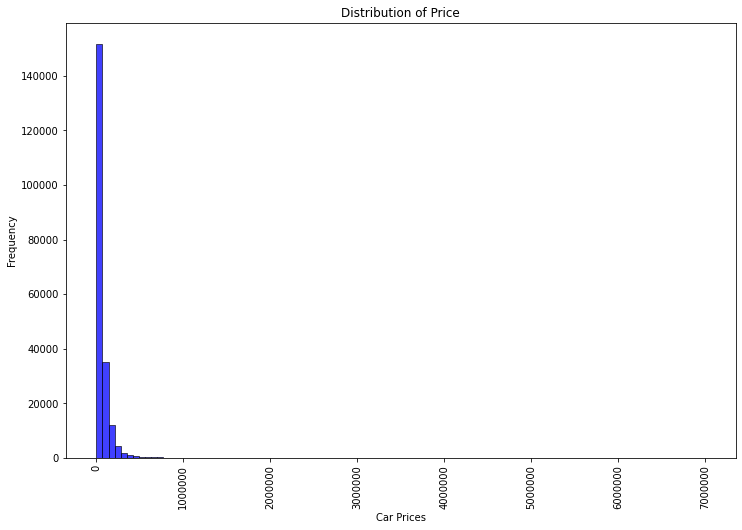

In [14]:
skew = plot_hist(car_sales_df,'Price',100,'Car Prices',kde=True,formatter=True,skewness=True)

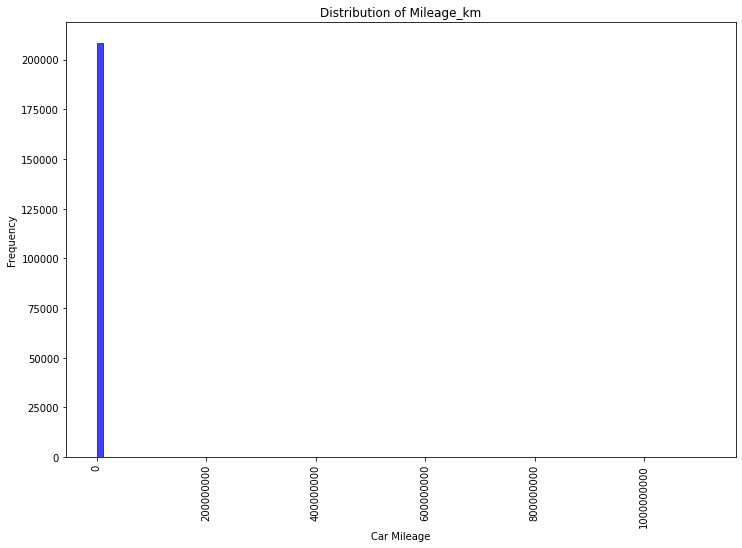

In [15]:
plot_hist(car_sales_df,'Mileage_km',100,'Car Mileage')

As we can see the distribution is heavily skewed.

## Feature Engineering

Before we proceed with Clustering, we would need to generate additional set of features, that will help with clustering. Vehicle age will help us understand how old the car is. We chose 2021 as base year since the dataset was formed and latest entry in the offer publication column in from May 2021. Additionally, we also created prod_reg_gap which is lag between vehicle production & registration. This will help us spot any potential anomalies.

In [16]:
#### Extracting registration year 
car_sales_df['first_registration_year'] = car_sales_df['First_registration_date'].dt.year

#### Calculating gap between production year & registration year. This feature would provide useful signal to spot anomalies in registration date column 
car_sales_df['prod_reg_gap'] = car_sales_df['first_registration_year'] - car_sales_df['Production_year']

#### Age of car
car_sales_df['car_age'] = 2021 - car_sales_df['Production_year']

## Clustering

In order to do the clustering & segment our vehicles in groups of similar feature, we will deploy following approach:

- Data Pre-Processing
- Feature Selection
- Algorithm Testing
- Cluster Visualization
- Results Interpretation

### Data Preprocessing

Most of our numerical features are on varying scales, for example, price of car in PLN/Euro with average of 63053 PLN & Number of Doors are single or double digits. We would need all of these features to have a common scale that ensures that all features contribute equally to the clustering process, regardless of their original range or units. Additionally, algorithms like K-Means assume that all features have comparable ranges. Thus, if features are not scaled, cluster centroids might skew toward high-value features. SO we would do **Feature Scaling.**

Moreover, most of the numerical features (Price, Mileage & Emissions) are highly skewed. If a feature has a highly right-skewed distribution, applying a log transformation can make the distribution closer to normal. This reduces the influence of extreme values (outliers) on the clustering process. Hence we would do **Log Transformation.**

**Finally, we would also convert relevant categorical features into numerical using one-hot encoding.**


In [17]:
car_sales_df_copy = car_sales_df.copy()

#### One Hot Encoding
col_lis = ['Condition','Type']
car_sales_df = pd.get_dummies(car_sales_df, columns=col_lis)

# List of features to be scaled and log-transformed (adjust based on your dataset)
features_to_scale = ['Price','car_age', 'Mileage_km','Power_HP','Displacement_cm3', 'CO2_emissions','prod_reg_gap','Doors_number']
features_to_log_transform = ['Price', 'Mileage_km','CO2_emissions']

# Scaling Features** for consistency across features
scaler = StandardScaler()  # or MinMaxScaler() if you prefer scaling between 0 and 1
scaler.fit(car_sales_df[features_to_scale])
car_sales_df[features_to_scale] = scaler.transform(car_sales_df[features_to_scale])

# Log Transformation** for skewed features
for feature in features_to_log_transform:
    car_sales_df[feature] = car_sales_df[feature].apply(lambda x: np.log1p(x) if x > 0 else 0)


### Feature Selection

For clustering, we will mostly focus on vehicle properties such as age, miles covered, price, etc sicne the gola is to segment them into clusters of similar properties. Thus we will select following features

In [18]:
cols_to_keep = ["Index",'Price','Mileage_km', 'Power_HP','Displacement_cm3', 'CO2_emissions', 'Doors_number','prod_reg_gap','car_age','Condition_New','Condition_Used']
car_feat_cluster = car_sales_df[cols_to_keep]
car_feat_cluster.head()

,Index,Price,Mileage_km,Power_HP,Displacement_cm3,CO2_emissions,Doors_number,prod_reg_gap,car_age,Condition_New,Condition_Used
0,0,0.237,0.000,-0.088,-0.663,0.000,-2.131,-0.090,-1.272,True,False
1,1,0.000,0.000,-0.989,-1.076,0.000,-3.432,10.041,5.444,False,True
2,2,0.000,0.000,0.362,-0.707,0.000,-2.131,-1.389,-0.843,False,True
3,3,0.000,0.000,0.105,-0.707,0.000,-2.131,0.169,0.014,False,True
4,4,0.338,0.000,0.169,-0.707,0.000,-2.131,-0.090,-1.272,True,False


Before moving ahead we will do correlation check to drop unneseccary features

In [19]:
correlation_matrix = car_feat_cluster[cols_to_keep].corr(method='pearson')  # Compute the correlation matrix

# Find the upper triangle of the correlation matrix
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
upper_triangle_matrix = correlation_matrix.where(upper_triangle)

# Find features with high correlation
threshold = 0.8
to_drop = [column for column in upper_triangle_matrix.columns if any(upper_triangle_matrix[column].abs() > threshold)]

print(f"Features to drop: {to_drop}")

Features to drop: ['Condition_Used']


## Algorithms to Test

### KMeans

We will start simple with KMeans since its distance based & fast algorithm. In order to chose the most optimal set of clusters, we will first use elbow technique

,Number of Clusters (k),WCSS
0,2,839678.621
1,3,677560.988
2,4,546899.877
3,5,457038.932
4,6,409040.126
5,7,377292.395
6,8,348320.287
7,9,332291.735


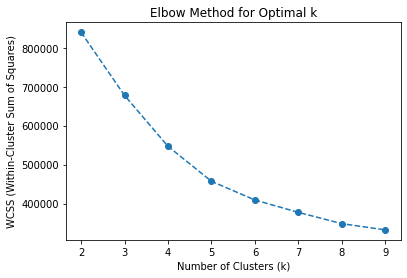

In [20]:
cols_to_keep = ['Price','Mileage_km', 'Power_HP','Displacement_cm3', 'CO2_emissions', 'Doors_number','prod_reg_gap','car_age','Condition_New']

# Run KMeans for different values of k
wcss = []  # Within-Cluster Sum of Squares (WCSS)

k_values = range(2, 10)  # Test k values from 2 to 10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(car_feat_cluster[cols_to_keep])
    wcss.append(kmeans.inertia_)  # Inertia is equivalent to WCSS
    
# Create a DataFrame
wcss_df = pd.DataFrame({'Number of Clusters (k)': list(k_values),'WCSS': wcss})
display(wcss_df)

plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.show()

From the looks of it, we can go ahead with k=4. But we will do  Davies-Bouldin Index (DBI) to evaluate the clustering performance. The DBI is a good metric to assess clustering quality, with lower values indicating better clustering.

In [21]:
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(car_feat_cluster[cols_to_keep])
    dbi = davies_bouldin_score(car_feat_cluster[cols_to_keep], labels)
    print(f"Davies-Bouldin Index for k={k}: {dbi:.3f}")

Davies-Bouldin Index for k=2: 1.270
Davies-Bouldin Index for k=3: 0.958
Davies-Bouldin Index for k=4: 0.950
Davies-Bouldin Index for k=5: 1.010
Davies-Bouldin Index for k=6: 1.065
Davies-Bouldin Index for k=7: 1.150
Davies-Bouldin Index for k=8: 1.126
Davies-Bouldin Index for k=9: 1.105


From Elbow Method & DBI score, it's safe to go with k=4. Now let's go ahead with running KMeans

In [22]:
cols_to_keep = ['Price','Mileage_km', 'Power_HP','Displacement_cm3', 'CO2_emissions', 'Doors_number','prod_reg_gap','car_age','Condition_New']

# Choose the optimal k from previous evaluations
optimal_k = 4  # Example, based on Elbow and Silhouette results
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(car_feat_cluster[cols_to_keep])
car_feat_cluster['Cluster'] = labels

For the visualization, we will us PCA. PCA reduces high dimentional data to 2D that will help us to evaluate & visualize the clustes.

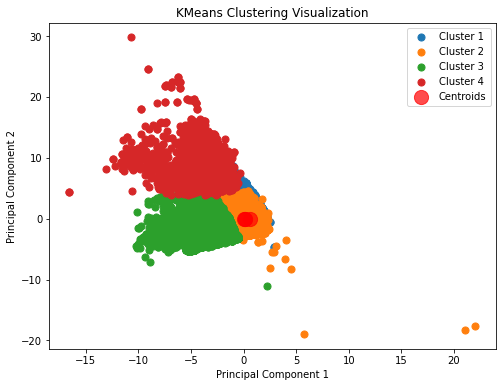

In [23]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(car_feat_cluster[cols_to_keep])

# Create the plot
plt.figure(figsize=(8, 6))

# Scatter plot for each cluster
unique_labels = np.unique(labels)
for label in unique_labels:
    plt.scatter(
        reduced_data[labels == label, 0],
        reduced_data[labels == label, 1],
        label=f'Cluster {label + 1}',  # Adding 1 to make clusters human-readable (1-based)
        s=50,
    )

# Plot centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c='red',
    s=200,
    alpha=0.7,
    label='Centroids'
)

# Add title, labels, and legend
plt.title('KMeans Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

The clusters look relatively less well separated & there are some apparent outliers. To proofcheck this, we will try another modelling approach

### GMM

KMeans assumes that our clusters would be spherical in nature & is distance based algoithm. Now we will try Gaussian Mixture Models.This is probabilistic approach.

First we will do parameter search to find the best set of n_compoents. For this we will start with 2 till 6, run GMM & calculate silhouette score. Higher the score, better the separation between the clusters.

In [24]:
cols_to_keep = ['Price','Mileage_km', 'Power_HP','Displacement_cm3', 'CO2_emissions', 'Doors_number','prod_reg_gap','car_age','Condition_New']

# Iterate through a smaller range of components to find the best based on silhouette score
best_silhouette = -1
best_components_silhouette = 0
silh_dict = {"n":[],"score":[]}

for n in [2,4,6]:  # Test for n_components = 2 to 10
    gmm = GaussianMixture(n_components=n, random_state=42)
    labels = gmm.fit_predict(car_feat_cluster[cols_to_keep])
    sil_score = silhouette_score(car_feat_cluster[cols_to_keep], labels)
    
    silh_dict["n"].append(n)
    silh_dict["score"].append(sil_score)
    
    if sil_score > best_silhouette:
        best_silhouette = sil_score
        best_components_silhouette = n

print(f"Optimal number of components based on Silhouette Score: {best_components_silhouette} (Silhouette Score: {best_silhouette:.2f})")

Optimal number of components based on Silhouette Score: 2 (Silhouette Score: 0.51)


We see that the optimla number of clusters would be 2. So let's go ahead with it

In [25]:
# Set optimal n_components 
optimal_components = 2 

gmm = GaussianMixture(n_components=optimal_components, random_state=42)
gmm.fit(car_feat_cluster[cols_to_keep])

# Predict cluster labels
labels = gmm.predict(car_feat_cluster[cols_to_keep])

# Add the cluster labels to the original DataFrame
car_feat_cluster['GMM_Cluster'] = labels

# Calculate Silhouette Score
sil_score = silhouette_score(car_feat_cluster[cols_to_keep], labels)
print(f'Silhouette Score: {sil_score:.2f}')

# Log-Likelihood
log_likelihood = gmm.score(car_feat_cluster[cols_to_keep])
print(f'Log-Likelihood: {log_likelihood:.2f}')


Silhouette Score: 0.51
Log-Likelihood: 4.70


In [23]:
cols_to_keep = ['Price','Mileage_km', 'Power_HP','Displacement_cm3', 'CO2_emissions', 'Doors_number','prod_reg_gap','car_age','Condition_New']

# Set optimal n_components 
optimal_components = 2 

gmm = GaussianMixture(n_components=optimal_components, random_state=42)
gmm.fit(car_feat_cluster[cols_to_keep])

# Predict cluster labels
labels = gmm.predict(car_feat_cluster[cols_to_keep])

# Add the cluster labels to the original DataFrame
car_feat_cluster['GMM_Cluster'] = labels

# Log-Likelihood
log_likelihood = gmm.score(car_feat_cluster[cols_to_keep])
print(f'Log-Likelihood: {log_likelihood:.2f}')


Log-Likelihood: 4.70


As expected, for 2 clusters, the Silhoutter Score is good. Now let's go ahead & plot visualize the clusters using PCA

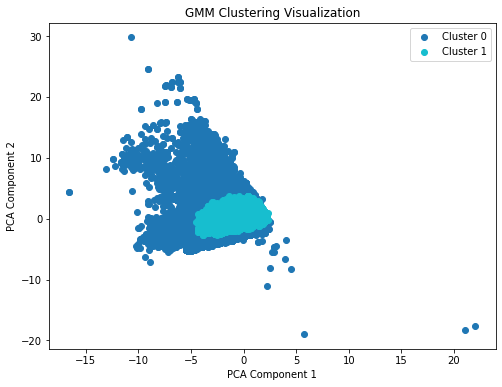

In [28]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(car_feat_cluster[cols_to_keep])

# Get centroids of each cluster
centroids = np.array([reduced_data[labels == i].mean(axis=0) for i in range(optimal_components)])

# Sort clusters based on centroid positions in PCA space (2D)
sorted_centroids_indices = np.argsort(centroids[:, 0])  # Sort by the first principal component

# Create a new label mapping
sorted_labels = np.array([np.where(sorted_centroids_indices == label)[0][0] for label in labels])

# Define a color map
cmap = plt.cm.get_cmap('tab10', optimal_components)

# Plot the clusters
plt.figure(figsize=(8, 6))
for cluster in range(optimal_components):
    cluster_points = reduced_data[sorted_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', color=cmap(cluster))

plt.title('GMM Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

From the first inspection, it looks like cluster 01 has majority of the entries since it's bigger in size while cluster 1 is less entries. This might indicate that cluster 1 entries would be outliers or anomalies. Let's validate that  

In [25]:
# Analyze the size of each cluster
car_feat_cluster['GMM_Cluster'].value_counts()

GMM_Cluster
0    187677
1     20627
Name: count, dtype: int64

As we can see, majority of the observations are assigned to cluster 0, while small number of observations are kept in cluster 1. Let's now examine within cluster stats

In [26]:
print('\nCluster Means:')
means_df = pd.DataFrame(gmm.means_, columns=cols_to_keep)
means_df.index = [f'Cluster {i}' for i in range(gmm.n_components)]
display(means_df)


Cluster Means:


,Price,Mileage_km,Power_HP,Displacement_cm3,CO2_emissions,Doors_number,prod_reg_gap,car_age,Condition_New
Cluster 0,0.127,0.012,-0.139,-0.144,0.000,0.073,-0.076,-0.034,0.107
Cluster 1,0.516,0.013,1.257,1.302,0.001,-0.654,0.687,0.309,0.260


It is evident that entries in cluster 1 have high average price, enginer power, age & displacement. And since these are so less in numbers, these would be outliers.

Let's do last validation on this

In [29]:
df_val = pd.merge(car_sales_df,car_feat_cluster[['Index','GMM_Cluster']],on=['Index'],how='inner')
df_val['GMM_Cluster'].value_counts(normalize=True)*100

GMM_Cluster
0   90.098
1    9.902
Name: proportion, dtype: float64

In [31]:
### Check entries in cluster 0

df_val[df_val['GMM_Cluster']==1][cols_to_keep].describe()

,Price,Mileage_km,Power_HP,Displacement_cm3,CO2_emissions,Doors_number,prod_reg_gap,car_age
count,20627.000,20627.000,20627.000,20627.000,20627.000,20627.000,20627.000,20627.000
mean,0.514,0.013,1.261,1.311,0.001,-0.658,0.693,0.317
std,0.661,0.083,1.984,1.979,0.056,1.610,3.087,1.914
min,0.000,0.000,-1.941,-2.038,0.000,-6.034,-31.005,-1.272
25%,0.000,0.000,-0.294,-0.116,0.000,-0.829,-0.610,-1.129
50%,0.159,0.000,0.633,0.437,0.000,0.472,-0.090,-0.272
75%,0.925,0.013,2.678,2.886,0.000,0.472,1.468,1.014
max,4.395,5.940,16.033,8.960,6.014,65.526,51.867,13.874


As we can see, car Price, Mileage, Displacement & Emissions have abnormally high values for cluser 1. This validates our hypothesis of cluster 1 being outliers.

**Conclusion:** The KMeans did not help as much to spot outliers but it did give us 4 clusters of nearly balanced size while GMM did spot outliers well. Since goal of this exercise is to do vehicle segmentation of similar properties, we will go ahead with KMeans & see what segments we get



### Results Interpretation

For KMeans: Let's Look at the results for KMeans in detail

In [24]:
df = pd.DataFrame(car_feat_cluster, columns=car_feat_cluster.columns)  # Replace with actual feature names

# View cluster profiles
cluster_profiles = df.groupby('Cluster').mean()
cluster_profiles.reset_index(inplace=True)
display(cluster_profiles)

,Cluster,Index,Price,Mileage_km,Power_HP,Displacement_cm3,CO2_emissions,Doors_number,prod_reg_gap,car_age,Condition_New,Condition_Used
0,0,101376.614,0.028,0.018,-0.376,-0.200,0.000,-1.888,0.072,0.807,0.019,0.981
1,1,109278.504,0.134,0.011,-0.225,-0.261,0.000,0.372,-0.085,-0.162,0.141,0.859
2,2,67435.220,0.597,0.013,2.252,2.214,0.001,-0.398,-0.046,-0.084,0.118,0.882
3,3,103759.943,0.160,0.020,-0.142,1.442,0.000,-1.968,9.972,5.299,0.000,1.000


**Based on the mean values for each cluster, we can draw follwing conclusions:**

**Cluster 0** (Low Price, Low Power, Newer Cars):
-  Price: Very low price (0.028), which suggests that the cars in this cluster are very affordable or budget models.
- Mileage: Low mileage (0.018), which likely indicates these are relatively new or lightly used cars.
- Power: Negative engine power value (-0.376), which could suggest that these cars are either low-powered or have smaller engines.
- Displacement: Slightly negative displacement value (-0.2), indicating smaller engine sizes.
- CO2 Emissions: Zero emissions, implying these are environmentally friendly vehicles.
- Doors Number: Very low number of doors (-1.888), which might indicate a smaller car type (e.g., two-door models).
- Production Registration Gap: Positive value (0.072), which may indicate the car is from a recent production year with a small gap between production and registration.
- Car Age: Car age is relatively high (0.807), which could mean that, even if these cars are affordable, they may not be brand new.
- Condition: The car is mostly used (0.981 in Condition_Used and 0.019 in Condition_New), likely indicating these cars are predominantly second-hand.

**Cluster 1** (Moderate Price, Older Models, Low Power):
- Price: Moderate price (0.134), suggesting these are mid-range or affordable cars but not necessarily budget.
- Mileage: Very low mileage (0.011), likely indicating the cars are lightly used or still in good condition.
- Power: Low power (-0.225), indicating the cars in this cluster are likely compact or economical with less powerful engines.
- Displacement: Negative displacement value (-0.261), consistent with small engine sizes.
- CO2 Emissions: Zero emissions (0), suggesting the cars are eco-friendly or newer models with efficient engines.
- Doors Number: Positive value (0.372), likely indicating standard cars with more doors, such as sedans or hatchbacks.
- Production Registration Gap: Negative value (-0.085), indicating a relatively older production year.
- Car Age: Negative age value (-0.162), which likely represents older used cars in this cluster.
- Condition: These cars have a mix of new and used conditions, with 0.141 for new and 0.859 for used, indicating that most of these cars are used.

**Cluster 2** (High Price, High Power, Newer Cars):
- Price: High price (0.597), suggesting these are premium or luxury cars with a higher cost.
- Mileage: Very low mileage (0.013), which likely indicates that these cars are newer or have been lightly used.
- Power: High power (2.252), indicating these are high-performance cars with powerful engines.
- Displacement: High displacement (2.214), consistent with larger, more powerful engines.
- CO2 Emissions: Small emissions (0.001), suggesting they are relatively eco-friendly despite their larger engines.
- Doors Number: Slightly negative (-0.398), possibly indicating fewer doors, which could reflect a sportier or more compact design.
-Production Registration Gap: Negative value (-0.046), showing that these are newer models with a short gap between production and registration.
- Car Age: Negative value (-0.084), indicating these cars are relatively young.
- Condition: These cars are primarily in used condition (0.882), with only a small portion being new (0.118), implying they are second-hand but in good condition.

**Cluster 3** (Moderate Price, Older Cars, High Production Gap):
- Price: Moderate price (0.16), indicating affordable or budget cars but not the cheapest.
- Mileage: Low mileage (0.02), suggesting these cars are in relatively good condition despite being older.
- Power: Slightly negative power (-0.142), indicating low to moderate engine power.
- Displacement: Positive displacement (1.442), which might imply larger engines or older car designs.
- CO2 Emissions: Zero emissions, indicating efficient or eco-friendly cars.
- Doors Number: Highly negative value (-1.968), suggesting these cars might be compact or older two-door models.
- Production Registration Gap: Very high (9.972), indicating these cars may have been produced several years ago but registered recently, which suggests older models.
- Car Age: Very high car age value (5.299), confirming that these are likely older models.
- Condition: These cars are used (with 1 in Condition_Used), which means they are all second-hand cars.


**In Summary:**

Cluster 0: Budget-friendly, low-powered, relatively new, eco-friendly cars, mostly second-hand with a small gap between production and registration.

Cluster 1: Mid-range priced, older cars with low power, low mileage, and a mix of new and used conditions, mostly used cars.

Cluster 2: Premium, high-powered, newer cars with low mileage, eco-friendly despite high engine sizes, mostly used but in good condition.

Cluster 3: Affordable older cars with moderate power, larger engines, low mileage, and a significant gap between production and registration, all second-hand.

## Conclusion

Based on our cluster analysis, following business implications & use cases can be drawn:

Customer Segmentation: These clusters can guide businesses in identifying customer segments based on their preferences for price, condition (new vs. used), car performance, and age. Tailored marketing campaigns can target the specific needs and behaviors of each cluster.

Inventory Management: Car dealerships can optimize their inventory based on the clusters. For instance, inventory for Cluster 0 should include budget and used cars, while Cluster 2 would require high-end, performance-focused vehicles. This can help maximize sales by matching supply to demand.

Product Offering: Businesses can consider introducing new car models that target the specific characteristics of each cluster. For example, a budget-friendly but feature-rich car that fits Cluster 0, or a high-performance sports model for Cluster 2.

Loyalty Programs: Offering tailored loyalty programs or after-sales packages can help retain customers in each cluster. For example, Cluster 1 might benefit from service discounts and free maintenance, while Cluster 3 might appreciate low-cost servicing or warranties.

Brand Positioning: Brands can position themselves according to the clusters they wish to target. For example, a brand emphasizing eco-friendliness might focus on Cluster 0, while a brand associated with high performance can aim at Cluster 2.

By understanding these clusters, businesses can align their strategies with customer preferences and expectations, leading to better marketing efforts, increased sales, and improved customer satisfaction.